# Sample_Kaggle_Submission-DSI-9

### 02_Preprocessing_and_Feature_Engineering.ipynb  

## <font color='green'> Content:

2 [Feature Engineering:](#Feature-Engineering:)
-----------------------------------------------------------
* [Exploratory Visualizations](#Exploratory-Visualizations)
* [Feature Engineering:](#Feature-Engineering:)
* [Revisiting Exploratory Data Analysis: Correlations Deep Dive](#Revisiting-Exploratory-Data-Analysis:-Correlations-Deep-Dive)

[Preprocessing](#Preprocessing)
----------------------------------------------------------------------------
* [Dummy Variables Creation](#Dummy-Variables-Creation)
* [Determine Baseline Score](#Determine-Baseline-Score)]
* [Linear Regression](#Linear-Regression)
* [Store Clean Data](#Store-Clean-Data)

----------------------------------------

## Exploratory Visualizations

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy import stats
from statsmodels.graphics.gofplots import qqplot
from sklearn.preprocessing import LabelEncoder
from scipy.stats import norm, skew, boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV, Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, FunctionTransformer, Imputer
from sklearn.pipeline import Pipeline, FeatureUnion # These ones are new!


sns.set_style('whitegrid')
%matplotlib inline

In [2]:
# Load Data from Part 1
%store -r df_train
%store -r df_test

In [3]:
df_train.shape

(2030, 79)

In [4]:
df_test.shape

(879, 78)

In [5]:
#Return just the columns with null values and number of nulls
nulls = df_train.isnull().sum()
nulls = nulls[nulls > 0]
nulls


Series([], dtype: int64)

In [6]:
# Null values for test data set
nulls_test = df_test.isnull().sum()

# The data set with null values that are greater than 0
nulls_test = nulls_test[nulls_test > 0]


#### Based on EDA and cleaning data process the features that I will not be including in my model will be ones with a large quantity of null values. (Explantion is in the part I)
#### To exclude: Alley, Pool QC, Misc Feature, Fence, Fireplace Qu.
#### For the other features, it will be important to replace the null values with a string in order to plot relationships.

In [7]:
#Create a list of features to exclude to keep track of features to exclude throughout analysis
to_exclude=[]

In [8]:
# Set null values in string types to 'None' for modeling purposes and graphing
# IF there is 'None' means the property does not have that related feature
# ie. 'None' in Alley or Bsmt -> no alley, no basement
df_train[nulls.index] = df_train[nulls.index].fillna('None')

In [9]:
# Apply same logic as above to test dataset
df_test[nulls_test.index] = df_test[nulls_test.index].fillna('None')

In [10]:
type(to_exclude)

list

In [11]:
to_exclude.extend(['alley', 'pool_qc', 'misc_feature', 'fence', 'fireplace_qu'])

In [12]:
to_exclude

['alley', 'pool_qc', 'misc_feature', 'fence', 'fireplace_qu']

In [13]:
df_test[nulls_test.index] = df_test[nulls_test.index].fillna('None')

In [14]:
# Return just the columns with 0 values and number of 0s
zeroes = (df_train == 0).sum()
zeroes = zeroes[zeroes > 0]
zeroes

lot_frontage        324
mas_vnr_area       1229
bsmtfin_sf_1        653
bsmtfin_sf_2       1786
bsmt_unf_sf         161
total_bsmt_sf        51
2nd_flr_sf         1172
low_qual_fin_sf    1997
bsmt_full_bath     1196
bsmt_half_bath     1906
full_bath             8
half_bath          1297
bedroom_abvgr         5
kitchen_abvgr         2
fireplaces          997
garage_yr_blt       114
garage_cars         114
garage_area         114
wood_deck_sf       1064
open_porch_sf       906
enclosed_porch     1709
3ssn_porch         2004
screen_porch       1851
pool_area          2023
misc_val           1967
dtype: int64

In [15]:
# Plotting functions to be used throughout for analysis
# Function for plotting multiple scatter plots
# Set default of y variable to Sale Price


def subplot_scatter(dataframe, list_of_columns, list_of_titles, y = 'saleprice'):
    nrows = int(np.ceil(len(list_of_columns)/2))         
    fig, ax = plt.subplots(nrows, ncols=2, figsize = (15,15))        
    ax = ax.ravel()                           
    for i, column in enumerate(list_of_columns):        
        sns.scatterplot(x = dataframe[column], y = dataframe[y], data = dataframe,
                       ax = ax[i])                   
        ax[i].set_title(list_of_titles[i])                               
    plt.subplots_adjust(top = 3, wspace = 0.5, hspace = .5)

    
# Function to plot multiple histograms 
def plot_dist(dataframe, list_of_columns, list_of_titles):
    nrows = int(np.ceil(len(list_of_columns)/2))         
    fig, ax = plt.subplots(nrows, ncols=2, figsize = (10,10))        
    ax = ax.ravel()                           
    for i, column in enumerate(list_of_columns):        
        ax[i].hist(dataframe[column])           
        ax[i].set_title(list_of_titles[i])                               
    plt.subplots_adjust(top = 3, wspace = 0.5, hspace = .5)
    
    
# Function to plot multiple box plots
def plot_box(dataframe, list_of_columns, list_of_titles):
    nrows = int(np.ceil(len(list_of_columns)/2))         
    fig, ax = plt.subplots(nrows, ncols=2, figsize = (15,20))        
    ax = ax.ravel()                           
    for i, column in enumerate(list_of_columns):        
        sns.boxplot(x = dataframe[column], y = dataframe['saleprice'], ax = ax[i])            
        ax[i].set_title(list_of_titles[i])                               
    plt.subplots_adjust(top = 3, wspace = 0.5, hspace = .5)

# Function will plot just ONE sns scatterplot with the y variable always set to price 
def scatterp(x,ax, y = 'saleprice', d = df_train):
    return sns.scatterplot(x = x, y = y, data = d, ax= ax)

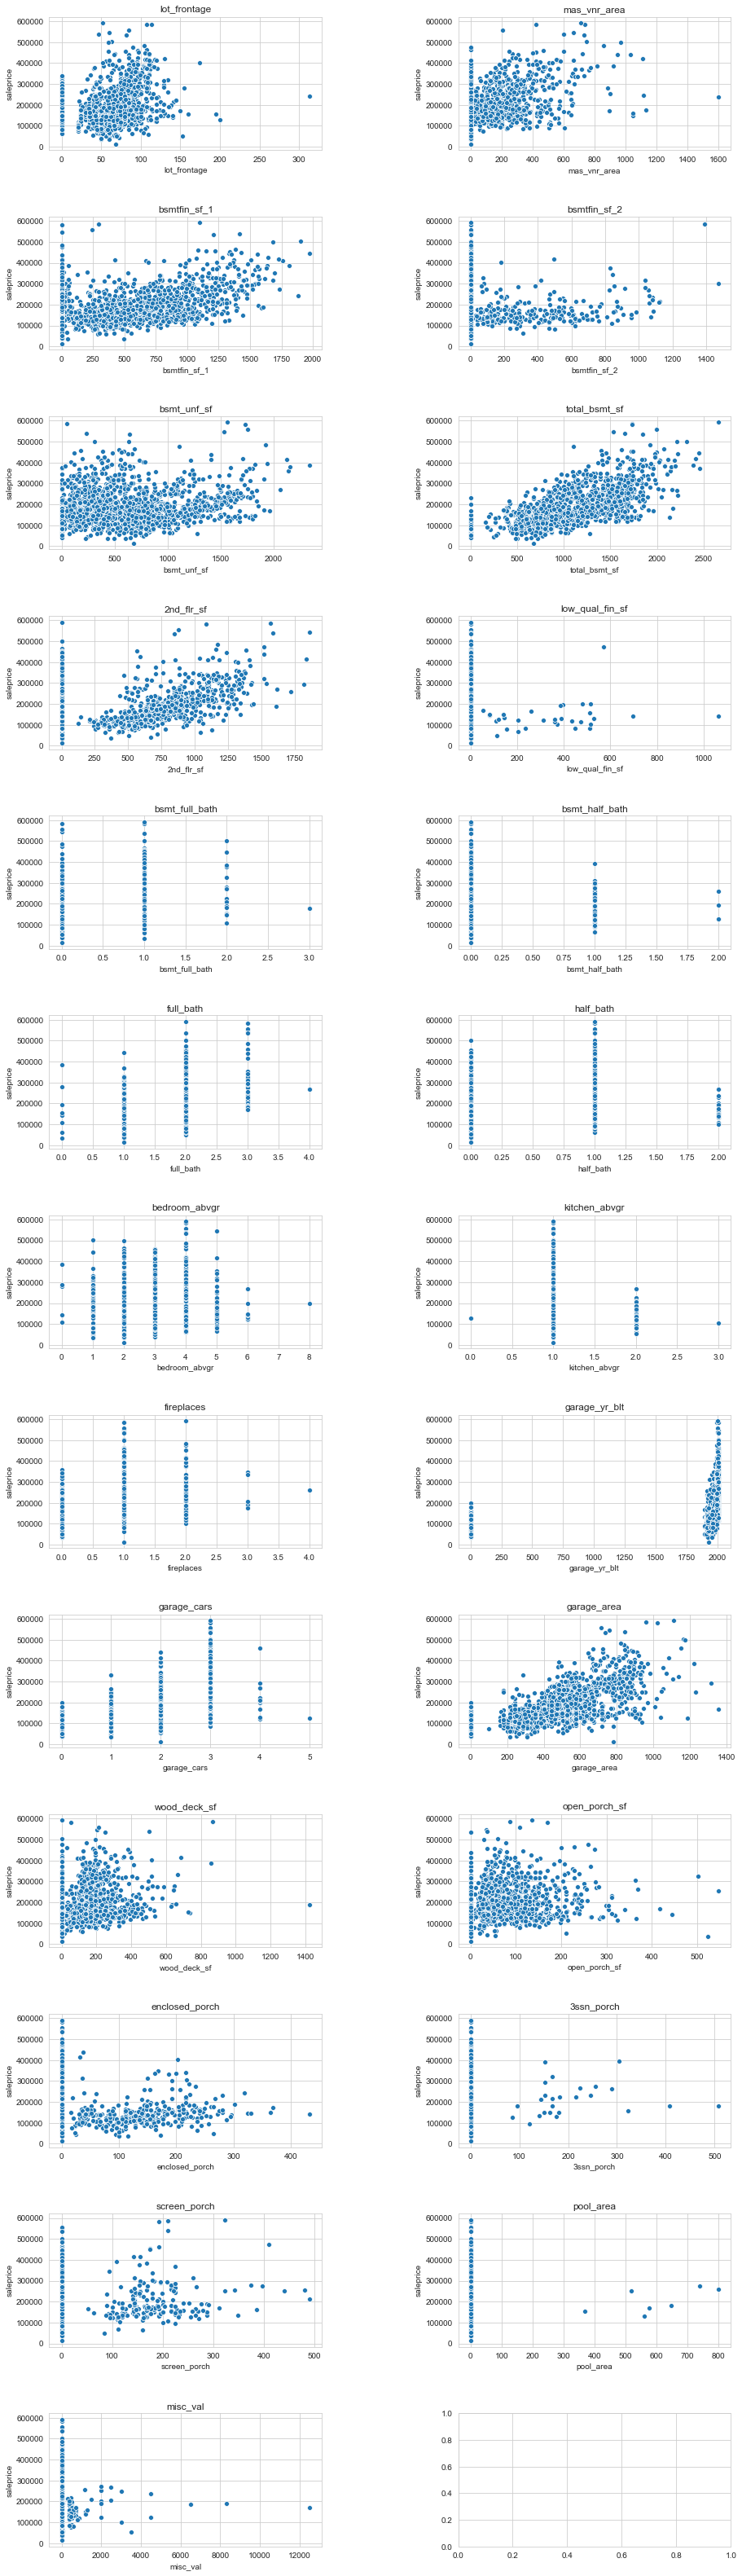

In [16]:
# Plot the relationship between sale price and columns with zero values in order to visualize which features 
# will remain relevant to the model
subplot_scatter(df_train, 
               zeroes.index,
               zeroes.index)


**Observation** Based on scatter I can remove BsmntFin SF 2, Bsmt Unf SF, Low Qual Fin SF, Garage Yr Blt, 35sn Porch, Pool Area, Screen Porch, Misc Val

In [17]:
#Add the new values to exclude in exclusion list
to_exclude.extend(['bsmtfin_sf_2', 'bsmt_unf_sf', 'low_qual_fin_sf', 'garage_yr_blt', '3ssn_porch', 'pool_area', 
                   'screen_porch', 'mas_vnr_area','misc_val'])

In [18]:
print(to_exclude)

['alley', 'pool_qc', 'misc_feature', 'fence', 'fireplace_qu', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'low_qual_fin_sf', 'garage_yr_blt', '3ssn_porch', 'pool_area', 'screen_porch', 'mas_vnr_area', 'misc_val']


In [19]:
# Create a list of integer type column names
int_types = df_train.dtypes == 'int'
int_types = int_types[int_types == True].index


# Create a list of float type column names
float_types = df_train.dtypes == 'float'
float_types = float_types[float_types == True].index

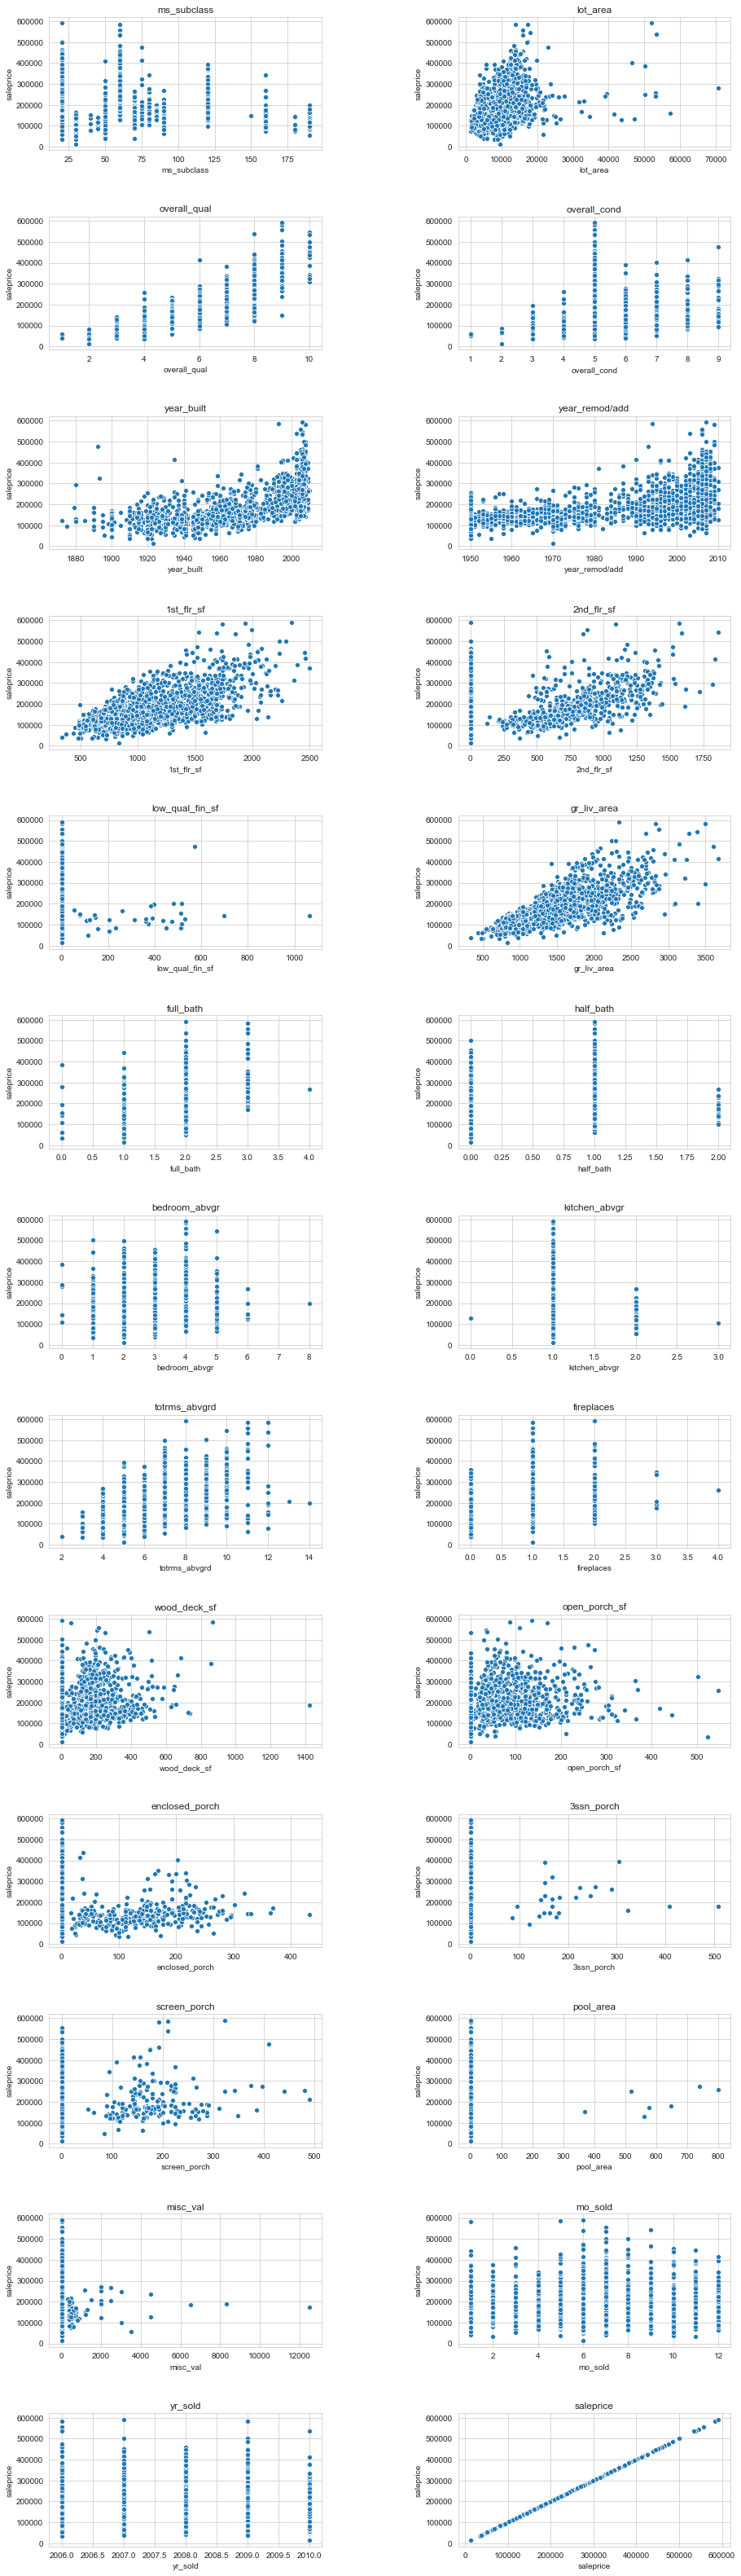

In [20]:
# Plotting price vs integer values
subplot_scatter(df_train, 
               int_types,
               int_types)


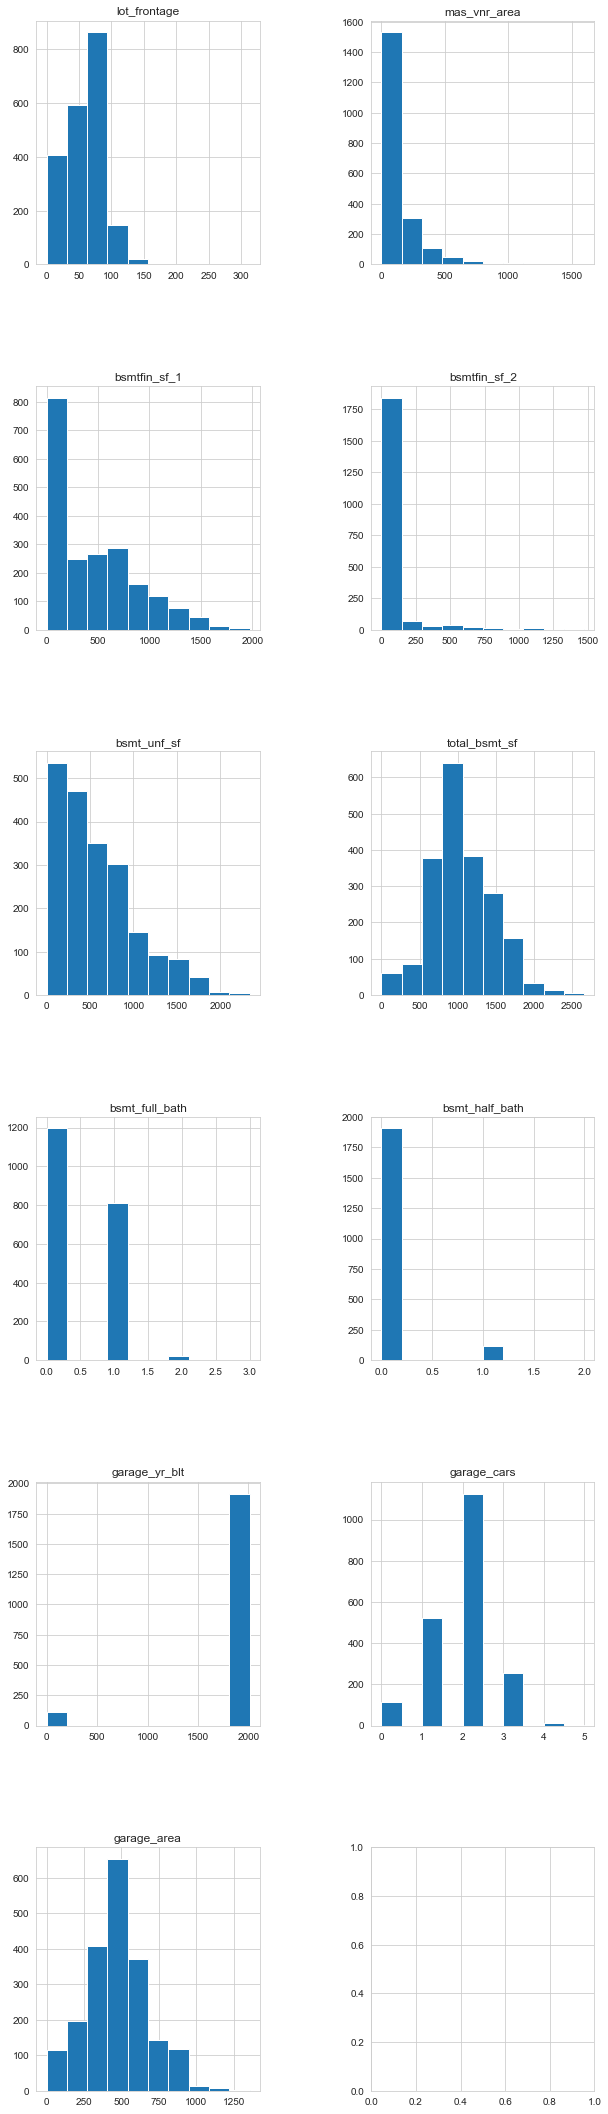

In [21]:
# Plot histogram for float types to check for normal distribution or see if there are any features to change
plot_dist(df_train, float_types, float_types)

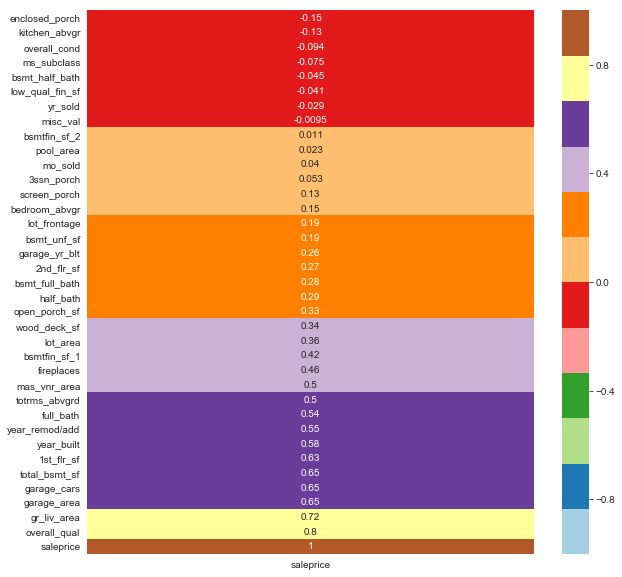

In [22]:
# Heat map of correlations to saleprice
fig, ax = plt.subplots(figsize = (10,10))

sns.heatmap(df_train.corr()[['saleprice']].sort_values('saleprice'), cmap = 'Paired', vmin= -1, ax = ax, annot= True);

In [23]:
#Check to see which correlations stand out with a filter since heatmap is very large
# Interesting values > .5 or < -.5
corr_saleprice = df_train.corr()['saleprice']
corr_saleprice[(corr_saleprice > .5) | (corr_saleprice < -.5)]

overall_qual      0.803786
year_built        0.577499
year_remod/add    0.554032
total_bsmt_sf     0.650742
1st_flr_sf        0.634269
gr_liv_area       0.717254
full_bath         0.541157
totrms_abvgrd     0.500409
garage_cars       0.650888
garage_area       0.653782
saleprice         1.000000
Name: saleprice, dtype: float64

### Based on my research and close relationship with the target variable I chose to include in our model following features:
- Overall Qual
- Year Built 
- Year Remod/Add
- Gr Liv Area
- Mas Vnr Area
- Garage Area

### Also, I would pay very close attention to neighbohood and street

In [24]:
remaining_features = df_train.drop(to_exclude, axis = 1)

In [25]:
def return_num(df, list_of_cols):
    num_list = []
    for lis in list_of_cols:
        
        # Exclude nulls and check type to see if float or int
        if df[lis].dtype == 'float64' or df[lis].dtype == 'int':
            num_list.append(lis) 
    return num_list

In [26]:
# the remaining features that have not yet been sorted 
num_remaining = return_num(df_train, remaining_features)

In [27]:
to_exclude.extend(['mo_sold', 'yr_sold', 'fireplaces', 'bedroom_abvgr', 
                   'kitchen_abvgr', 'bsmt_half_bath', 'half_bath', 'bsmt_full_bath'])

#### I ran scatter plot to check on numericla columns that are not part of my exlusion group and based on a graph I remove Mo Sold, Yr Sold, Fireplaces, Bedroom AbvGr, Kitchen AbvGr, Bsmt Half Bath, Half Bath, Bsmt Full Bath.(code the same as I created in line 65)

In [28]:
interesting = ['lot_frontage', 'lot_area', 'overall_qual', 
               'overall_cond', 'year_built', 'year_remod/add', 'total_bsmt_sf',
               'gr_liv_area', 'garage_area', 'enclosed_porch']

In [29]:
features =[]

In [30]:
# Appending the columns that were interesting (will have an impact on model) to features list 
# Will check to see if it is already part of the features list and if not, add to features
for feature in interesting: 
    if not feature in features: 
        features.append(feature)

In [31]:
# Check which features are now remaining 
# Should be just the remaining categorical/object types
obj_remaining = []
for feature in remaining_features: 
    if not feature in num_remaining: 
        obj_remaining.append(feature)

Some of the columns can have their NA values be converted to 0, an average/median/mode, or a category: "None".
With others, we can try to get a little clever by looking into the data description.

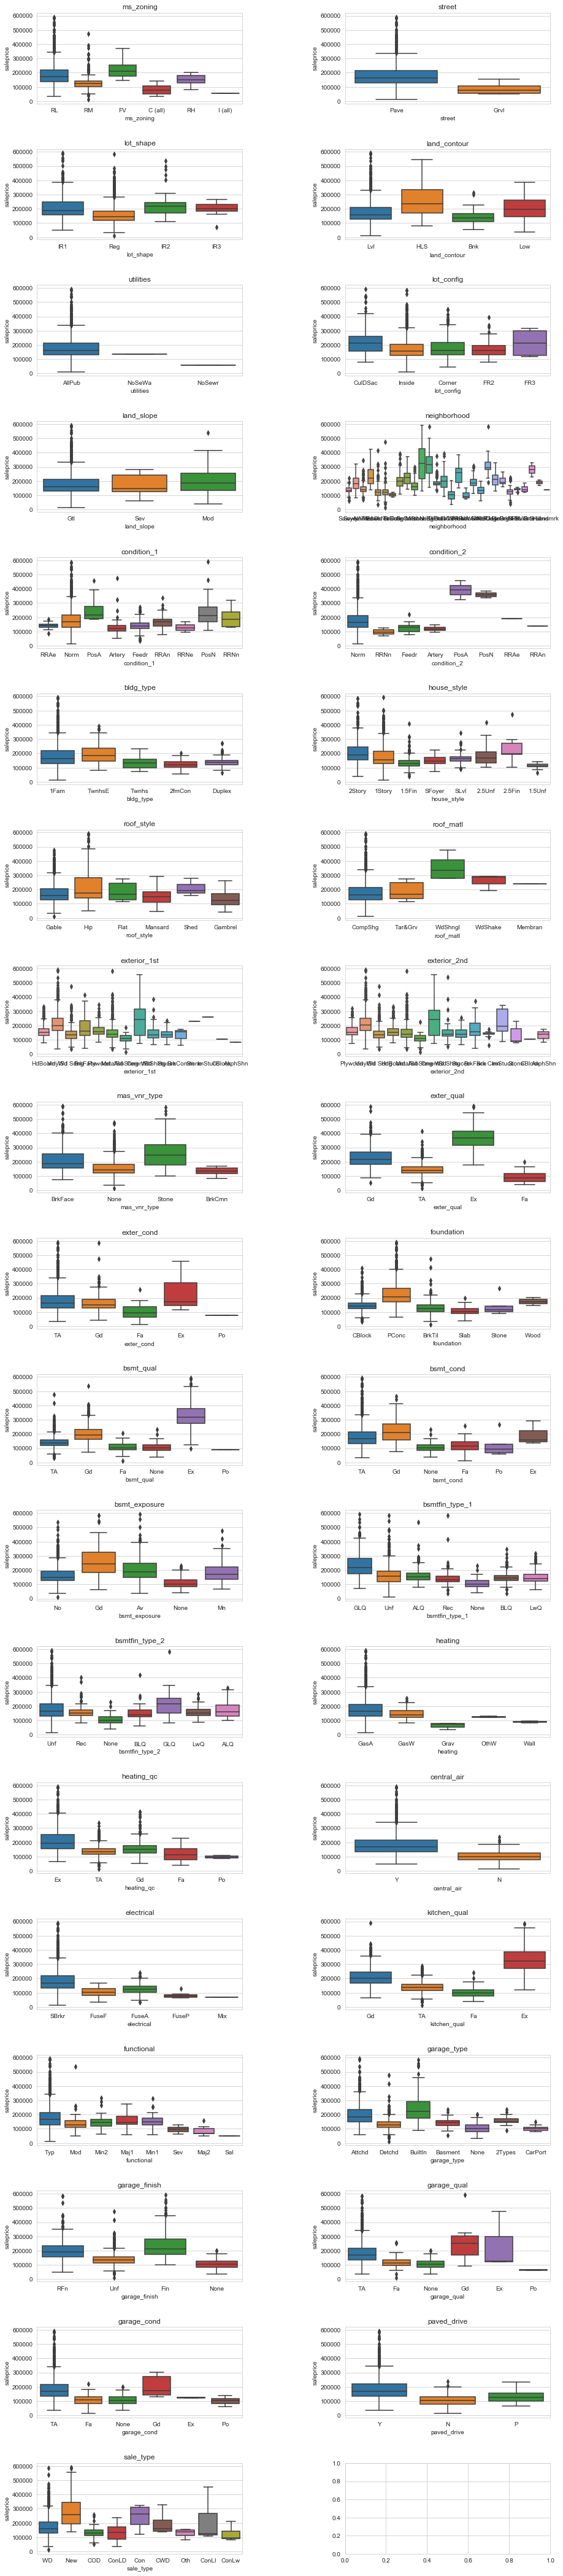

In [32]:
plot_box(df_train, obj_remaining, obj_remaining)

In [33]:
features.extend(['street', 'ms_zoning', 'utilities', 'neighborhood', 
                 'roof_style', 'foundation', 'bsmt_qual', 'bsmt_cond', 
                'bsmtfin_type_1', 'heating', 'heating_qc', 'central_air','electrical', 
                'kitchen_qual', 'functional', 'garage_type', 'paved_drive', 'lot_shape', 'bldg_type', 'land_contour', 
                'ms_subclass', 'house_style', 'land_slope', 'condition_1', 'bldg_type', 'exter_cond'])

## Feature Engineering:

In [34]:
# Code from https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/
corr_matrix = df_train.drop('saleprice', axis = 1).corr().abs()

# See which columns have high correlations and create interaction terms from the results

corr_matrix = df_train.drop('saleprice', axis = 1).corr().abs()

# Masking bottom half of the correlation matrix 
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


high_corr = [column for column in upper.columns if any(upper[column] > 0.7)]

In [35]:
high_corr

['1st_flr_sf', 'totrms_abvgrd', 'garage_area']

In [36]:
# Create interaction terms from high correlation variables 
df_train['garage_interaction'] = df_train['garage_area'] * df_train['garage_cars']
df_train['rms_interaction'] = df_train['totrms_abvgrd'] * df_train['gr_liv_area']

In [37]:
#Add garage interaction to features as it seems to be the most dependent on one another
features.append('garage_interaction')

In [38]:
print(features)

['lot_frontage', 'lot_area', 'overall_qual', 'overall_cond', 'year_built', 'year_remod/add', 'total_bsmt_sf', 'gr_liv_area', 'garage_area', 'enclosed_porch', 'street', 'ms_zoning', 'utilities', 'neighborhood', 'roof_style', 'foundation', 'bsmt_qual', 'bsmt_cond', 'bsmtfin_type_1', 'heating', 'heating_qc', 'central_air', 'electrical', 'kitchen_qual', 'functional', 'garage_type', 'paved_drive', 'lot_shape', 'bldg_type', 'land_contour', 'ms_subclass', 'house_style', 'land_slope', 'condition_1', 'bldg_type', 'exter_cond', 'garage_interaction']


In [39]:
df_train['saleprice'].count

<bound method Series.count of 0       130500
1       220000
2       109000
3       174000
4       138500
         ...  
2025    298751
2026     82500
2027    177000
2028    144000
2029    189000
Name: saleprice, Length: 2030, dtype: int64>

# Preprocessing

In [40]:
df_train['saleprice'].count

<bound method Series.count of 0       130500
1       220000
2       109000
3       174000
4       138500
         ...  
2025    298751
2026     82500
2027    177000
2028    144000
2029    189000
Name: saleprice, Length: 2030, dtype: int64>

## Dummy Variables Creation

In [41]:
# Get just the unique values of the features in case duplicates were added at some point 
features = set(features)

In [42]:
# Set X and y for modeling
X = df_train[features]
y = df_train['saleprice']

In [43]:
# Convert the categorical columns into processable numbers (turning into dummy variables)
# dummy variable = yes or no
X = pd.get_dummies(X, columns = ['street', 'ms_zoning', 'utilities', 'neighborhood', 
                 'roof_style', 'foundation', 'bsmt_qual', 'bsmt_cond', 
                'bsmtfin_type_1', 'heating', 'heating_qc', 'central_air','electrical', 
                'kitchen_qual', 'functional', 'garage_type', 'paved_drive',
                'house_style', 'lot_shape', 'land_contour', 'land_slope', 'condition_1', 'bldg_type', 'exter_cond'],drop_first = True)

In [44]:
X.tail()

,overall_qual,gr_liv_area,overall_cond,garage_interaction,total_bsmt_sf,enclosed_porch,lot_frontage,garage_area,lot_area,year_remod/add,...,condition_1_RRNe,condition_1_RRNn,bldg_type_2fmCon,bldg_type_Duplex,bldg_type_Twnhs,bldg_type_TwnhsE,exter_cond_Fa,exter_cond_Gd,exter_cond_Po,exter_cond_TA
2025,8,1728,5,1040.0,1884.0,0,79.0,520.0,11449,2007,...,0,0,0,0,0,0,0,0,0,1
2026,4,861,5,1078.0,861.0,0,0.0,539.0,12342,1950,...,0,0,0,0,0,0,0,0,0,1
2027,6,1913,6,684.0,896.0,0,57.0,342.0,7558,1950,...,0,0,0,0,0,0,0,0,0,1
2028,4,1200,5,294.0,1200.0,140,80.0,294.0,10400,1956,...,0,0,0,0,0,0,0,0,0,1
2029,7,1804,5,884.0,994.0,0,60.0,442.0,7500,1999,...,0,0,0,0,0,0,0,0,0,1


In [45]:
##Let's make some ordinal variables:

simple_qual_encoded = {
    'Ex': 5,
    'Gd': 4,
    'TA': 3,
    'Fa': 2,
    'Po': 1,
    'NA': 0,
    np.nan: 0
}

df_train['exter_qual'] = df_train['exter_qual'].map(simple_qual_encoded)
df_train['exter_cond'] = df_train['exter_cond'].map(simple_qual_encoded)
df_train['bsmt_qual'] = df_train['bsmt_qual'].map(simple_qual_encoded)
df_train['bsmt_cond'] = df_train['bsmt_cond'].map(simple_qual_encoded)
df_train['heating_qc'] = df_train['heating_qc'].map(simple_qual_encoded)
df_train['kitchen_qual'] = df_train['kitchen_qual'].map(simple_qual_encoded)
df_train['fireplace_qu'] = df_train['fireplace_qu'].map(simple_qual_encoded)
df_train['garage_qual'] = df_train['garage_qual'].map(simple_qual_encoded)
df_train['garage_cond'] = df_train['garage_cond'].map(simple_qual_encoded)
df_train['pool_qc'] = df_train['pool_qc'].map(simple_qual_encoded)


## Train-test-split

Before modeling, we will need to do a train-test-split to cross validate our model, then scale all our numeric features.

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [47]:
print(X.shape)
print(X_train.shape)
print(X_test.shape)

(2030, 135)
(1522, 135)
(508, 135)


In [48]:
y_train.shape

(1522,)

## Determine Baseline Score

In [49]:
# Import dummy regressor
from sklearn.dummy           import DummyRegressor

# Instantiate: creates a dummy regression that always predicts the mean of the target
base_mean = DummyRegressor(strategy='mean')

# Fit the "model"
base_mean = base_mean.fit(X_train, y_train)

# Get predictions for our testing set (not kaggle testing set)
y_hat_base_train = base_mean.predict(X_train)
y_hat_base_test = base_mean.predict(X_test)

# Get RMSE
from sklearn.metrics import mean_squared_error
print("Our Train RMSE Score for our Base Model is:",  np.sqrt(mean_squared_error(y_hat_base_train, y_train)))
print("Our Test RMSE Score for our Base Model is:",  np.sqrt(mean_squared_error(y_hat_base_test, y_test)))

Our Train RMSE Score for our Base Model is: 76627.49497744546
Our Test RMSE Score for our Base Model is: 75939.92087813758


## Linear Regression

In [50]:
# Instantiate 
lr = LinearRegression()

# Fit 
our_model = lr.fit(X_train, y_train)

In [51]:
# Predictions 
y_hat_lr_train = our_model.predict(X_train) # familiar data
y_hat_lr_test = our_model.predict(X_test)   # unseen/unfamiliar data

In [52]:
# Get RMSE
print("Our Train RMSE Score for our LR Model is:",  np.sqrt(mean_squared_error(y_train, y_hat_lr_train)))
print("Our Test RMSE Score for our LR Model is:",  np.sqrt(mean_squared_error(y_test, y_hat_lr_test)))

Our Train RMSE Score for our LR Model is: 20543.8036479782
Our Test RMSE Score for our LR Model is: 25923.555948980033


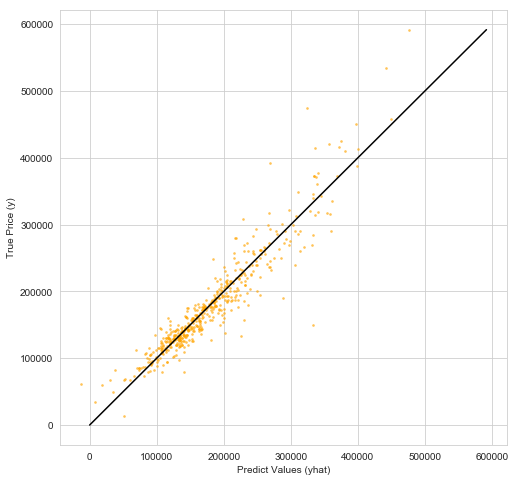

In [53]:
# Plot the model
plt.figure(figsize=(8,8))

# Generate a scatterplot of predicted values versus actual values.
plt.scatter(y_hat_lr_test, y_test, alpha = 0.5, s = 3, c = 'orange')
plt.xlabel('Predict Values (yhat)')
plt.ylabel('True Price (y)')

# This makes the 45 degree line
plt.plot([0, np.max(y)], [0, np.max(y)], c='k');

In [55]:
X_train.head()

,overall_qual,gr_liv_area,overall_cond,garage_interaction,total_bsmt_sf,enclosed_porch,lot_frontage,garage_area,lot_area,year_remod/add,...,condition_1_RRNe,condition_1_RRNn,bldg_type_2fmCon,bldg_type_Duplex,bldg_type_Twnhs,bldg_type_TwnhsE,exter_cond_Fa,exter_cond_Gd,exter_cond_Po,exter_cond_TA
1841,4,861,6,576.0,861.0,128,62.0,288.0,7404,1950,...,0,0,0,0,0,0,0,0,0,1
425,7,2312,5,1974.0,1177.0,0,0.0,658.0,15896,1999,...,0,1,0,0,0,0,0,0,0,1
1904,6,1440,7,934.0,1440.0,99,0.0,467.0,12546,1981,...,0,0,0,0,0,0,0,1,0,0
1837,5,990,5,1344.0,990.0,0,57.0,672.0,9245,1995,...,0,0,0,0,0,0,0,0,0,1
1170,7,1274,5,1016.0,1274.0,0,68.0,508.0,8814,2007,...,0,0,0,0,0,0,0,0,0,1


# Store Data for Part III

In [58]:
%store X_train
%store X_test
%store y_train
%store y_test
%store y_hat_lr_train
%store y_hat_lr_test
%store X
%store features
%store our_model
%store y

Stored 'X_train' (DataFrame)
Stored 'X_test' (DataFrame)
Stored 'y_train' (Series)
Stored 'y_test' (Series)
Stored 'y_hat_lr_train' (ndarray)
Stored 'y_hat_lr_test' (ndarray)
Stored 'X' (DataFrame)
Stored 'features' (set)
Stored 'our_model' (LinearRegression)
Stored 'y' (Series)
